![](2022-01-24-04-13-40.png)

# 한빛 마켓의 농산물 판매 이벤트 계획

- 고객이 사고 싶은 과일 사진을 보낸다
- 가장 많은 요청을 받은 과일을 판매하기로 계획
- 1위 과일을 보낸 사람들 중 몇 명은 이벤트 당첨자 선정

> 문제는 어떤 사진을 보낼지 모르는 상태로 일일이 분류를 할 수는 없다   
사진에 정답(타깃)을 모르는 상태에서 어떻게 사진을 분류할까??

## 비지도 학습
입력 데이터에 대하여 정답(레이블)이 정해지지 않은 데이터들을 학습하는 것   
머신은 각 데이터의 유사성에 따라 그룹화하고 숨겨진 구조와 패턴을 찾아 분석한다.   
그룹화 하는 것을 군집화(Clustering)라고 하며 K-평균 알고리즘, DBSCAN 알고리즘 등 다양한 알고리즘이 있다.   
군집 알고리즘에서 만든 그룹을 클러스터(Cluster)라고 한다.

## 픽셀값을 이용한 사진 분류로 결정

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fruits = np.load('data/fruits_300.npy')
print(fruits.shape)

(300, 100, 100)


np.load()는 npy 파일을 배열 로 불러올때 사용한다   

`fruits.shape`를 확인해보면 (300, 100, 100) 3차원 배열이 나온다. 각각의 값은 (개수, 높이, 너비)를 나타낸다.   
즉, 100x100 크기의 배열이 300개가 있다.


In [2]:
print(fruits[0,0,:])
# fruits의 첫 번째 사진에 첫번째 행, 열 전체

[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   1
   2   2   2   2   2   2   1   1   1   1   1   1   1   1   2   3   2   1
   2   1   1   1   1   2   1   3   2   1   3   1   4   1   2   5   5   5
  19 148 192 117  28   1   1   2   1   4   1   1   3   1   1   1   1   1
   2   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1]


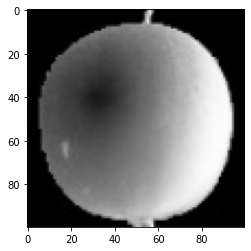

In [3]:
plt.imshow(fruits[0], cmap='gray')
plt.show()

![](m.png)

배경이 검은색이고 사과가 더 밝은 모양을 띄는 이유는 이미지를 numpy 배열로 변환할 때 반전 시켰기 때문이다  
알고리즘이 연산을 할 때 픽셀값이 0이면 출력도 0이 되어 의미가 없다. 반대로 픽셀값이 높을 수록 출력값도 커진다  

배경을 무시하기 위해서 배경이 검은색으로 나온다

보기 편하게 `cmap='gray_r'`로 변경해 준다

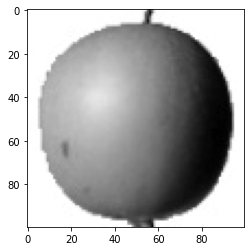

In [4]:
plt.imshow(fruits[0], cmap='gray_r')
plt.show()

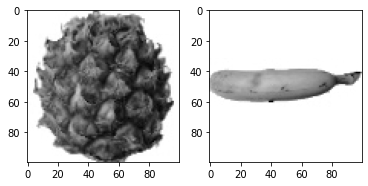

In [5]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(fruits[100], cmap='gray_r')
axs[1].imshow(fruits[200], cmap='gray_r')
plt.show()

#### matplotlib의 subplots() 함수

>subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)   
- nrows, cols = 행, 열   
![](2022-01-24-02-18-07.png)   


- sharex = (x or y)축을 공유한다   
![](2022-01-24-02-15-45.png)   
![](2022-01-24-02-16-03.png)   




### plt.subplot과 plt.subplots 차이

```
plt.subplot(2,1,1)
plt.subplot(2,1,2)
plt.show()
```
```
fig, axes = plt.subplots(2,1)
plt.show()
```

![](2022-01-24-02-21-11.png)


In [6]:
apple = fruits[0:100].reshape(-1, 100*100)
pineapple = fruits[100:200].reshape(-1, 100*100)
banana = fruits[200:300].reshape(-1, 100*100)

`reshape(-1, 100*100)`는 (300, 100, 100) 에서 (300, 100*100)의 2차원 배열로 변경   (개수, 픽셀)

In [7]:
print(apple.shape)
print(pineapple.shape)
print(banana.shape)

(100, 10000)
(100, 10000)
(100, 10000)


In [8]:
print(apple.mean(axis=1))
# print(pineapple.mean(axis=1))
# print(banana.mean(axis=1))

[ 88.3346  97.9249  87.3709  98.3703  92.8705  82.6439  94.4244  95.5999
  90.681   81.6226  87.0578  95.0745  93.8416  87.017   97.5078  87.2019
  88.9827 100.9158  92.7823 100.9184 104.9854  88.674   99.5643  97.2495
  94.1179  92.1935  95.1671  93.3322 102.8967  94.6695  90.5285  89.0744
  97.7641  97.2938 100.7564  90.5236 100.2542  85.8452  96.4615  97.1492
  90.711  102.3193  87.1629  89.8751  86.7327  86.3991  95.2865  89.1709
  96.8163  91.6604  96.1065  99.6829  94.9718  87.4812  89.2596  89.5268
  93.799   97.3983  87.151   97.825  103.22    94.4239  83.6657  83.5159
 102.8453  87.0379  91.2742 100.4848  93.8388  90.8568  97.4616  97.5022
  82.446   87.1789  96.9206  90.3135  90.565   97.6538  98.0919  93.6252
  87.3867  84.7073  89.1135  86.7646  88.7301  86.643   96.7323  97.2604
  81.9424  87.1687  97.2066  83.4712  95.9781  91.8096  98.4086 100.7823
 101.556  100.7027  91.6098  88.8976]


#### axis 인수

axis는 배열의 축을 의미한다. 
- `axis=0`이면 행을 따라 연산
- `axis=1`이면 열을 따라 연산

지금 예제의 사과 이미지로 생각해보면

`axis=0`이면 사과 이미지 하나에 대해 연산
`axis=1`이면 사과 이미지의 각 픽셀에 대한 연산 (0번 픽셀끼리 계산, 1번 픽셀끼리 계산...)


히스토그램(Histogram) = 도수분포표를 그래프로 나타낸 것, 가로축은 계급, 세로축은 도수(횟수 또는 개수)를 나타낸다  
   
>hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)  
  
- x = 배열(리스트)   
- bins = x축 개수 지정(default=10)    
![](2022-01-24-02-43-46.png)
- cumulative = True로 지정하면 누적 히스토그램을 보여줌 (default=False)   
![](2022-01-24-02-43-36.png)
- histtype = 히스토그램 종류 지정(bar, barstacked, step, stepfileed) (default='bar')  
![](2022-01-24-02-43-29.png)

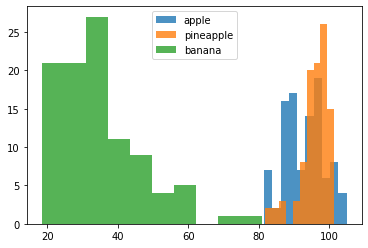

In [19]:
plt.hist(np.mean(apple, axis=1), alpha=0.8)
plt.hist(np.mean(pineapple, axis=1), alpha=0.8)
plt.hist(np.mean(banana, axis=1), alpha=0.8)
plt.legend(['apple', 'pineapple', 'banana'])
plt.show()

![](2022-01-24-02-56-19.png)

바나나는 사과 파인애플에 비해 픽셀이 차지하는 비율이 적기 때문에 평균이 낮게 나온다   
사과와 파인애플은 형태도 비슷하고 사진에서 픽셀이 차지하는 비율도 비슷해 비슷하게 나온다.

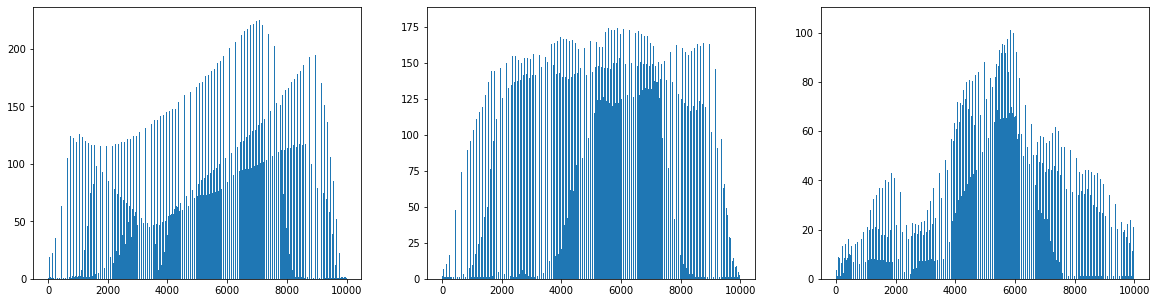

In [10]:
fig, axs = plt.subplots(1,3, figsize=(20, 5))
axs[0].bar(range(10000), np.mean(apple, axis=0))
axs[1].bar(range(10000), np.mean(pineapple, axis=0))
axs[2].bar(range(10000), np.mean(banana, axis=0))
plt.show()

가로(x)축은 각 픽셀의 인덱스
세로(y)축은 각 픽셀의 평균값

과일마다 높은 픽셀 값을 가지는 위치가 다르다

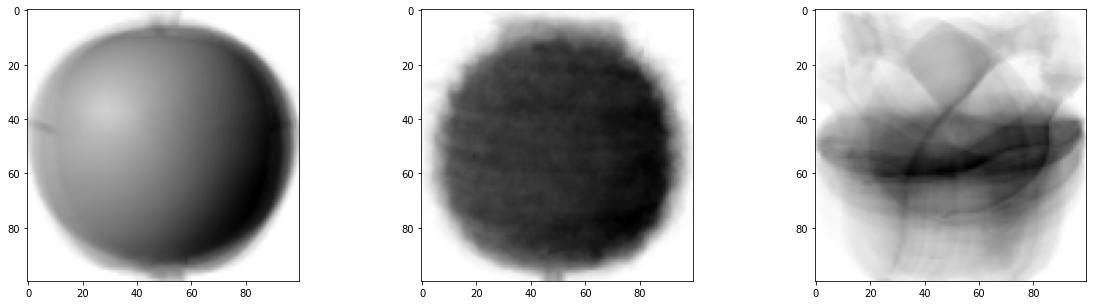

In [11]:
apple_mean = np.mean(apple, axis=0).reshape(100, 100)
pineapple_mean = np.mean(pineapple, axis=0).reshape(100, 100)
banana_mean = np.mean(banana, axis=0).reshape(100, 100)

fig, axs = plt.subplots(1, 3, figsize=(20,5))
axs[0].imshow(apple_mean, cmap='gray_r')
axs[1].imshow(pineapple_mean, cmap='gray_r')
axs[2].imshow(banana_mean, cmap='gray_r')
plt.show()

바나나가 저렇게 나온 이유는 아래 그림처럼 다양한 위치로 있을 수 있기 때문에   
![](2022-01-24-03-07-01.png)   


In [12]:
abs_diff = np.abs(fruits - apple_mean)
abs_mean = np.mean(abs_diff, axis=(1,2))
print(abs_mean.shape)

(300,)


# $평균절대오차(MAE) = \frac{1}{n} \displaystyle\sum_{i=1}^{n} \vert x_i + x \vert$

## $\vert x_i + x \vert$ == abs_diff   
## $\frac{1}{n} \displaystyle\sum_{i=1}^{n}$ == abs_mean   



abs_diff = 전체 과일에서 사과의 픽셀별 평균을 빼고 절대값으로 변환한 값   
   
abs_mean = 3차원 배열(300, 100, 100)이므로 `axis=(1,2)`(100, 100)에 대해 평균값을 계산한다   
따라서 (300,)로 1차원 배열이 생성된다.

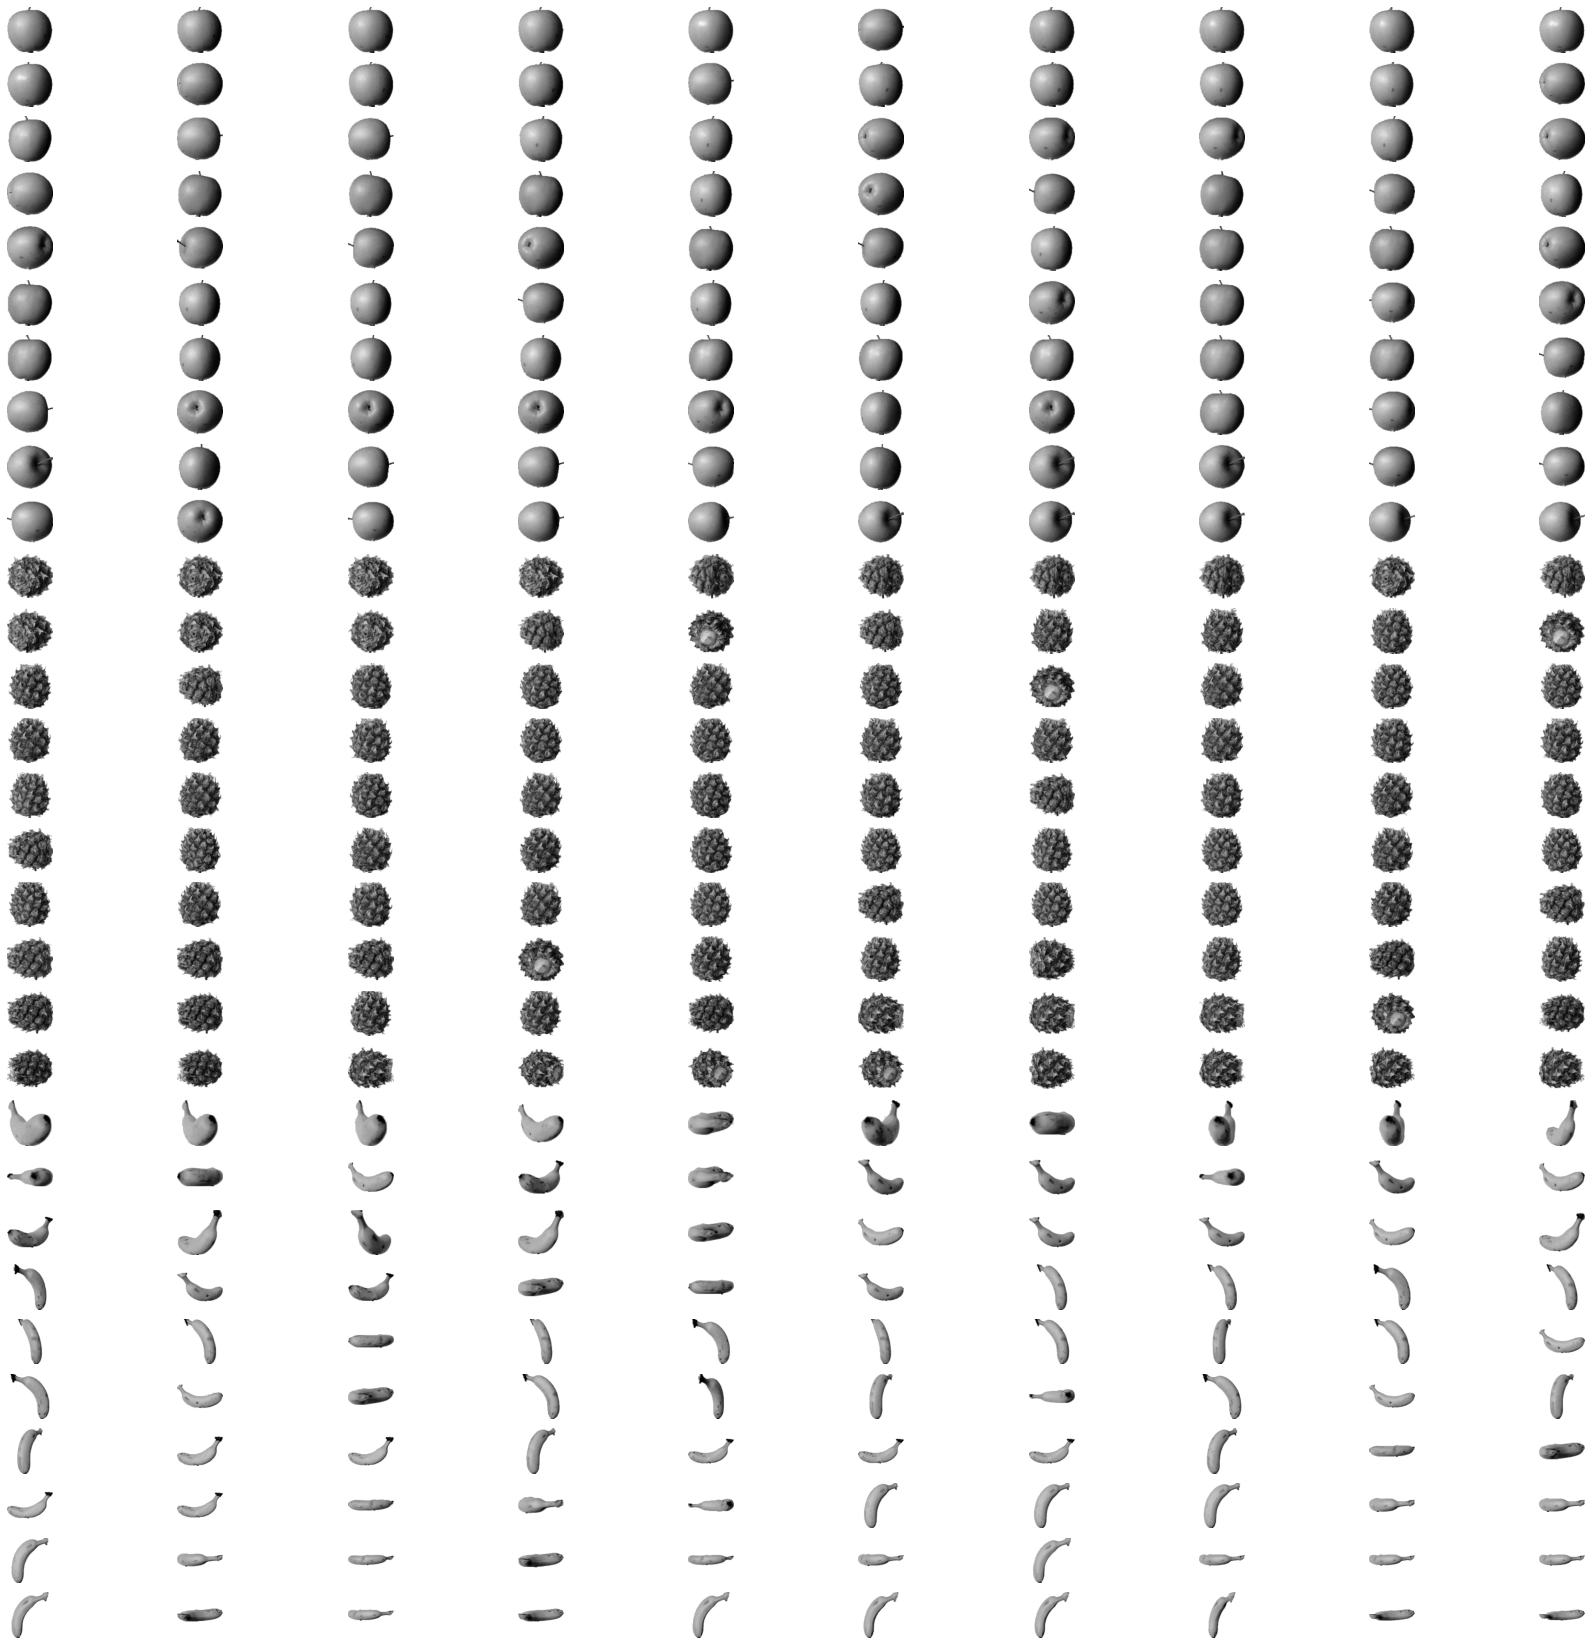

In [15]:
apple_index = np.argsort(abs_mean)[:]
fig, axs = plt.subplots(30, 10, figsize=(30,30))
for i in range(30):
    for j in range(10):
        axs[i, j].imshow(fruits[apple_index[i*10 + j]], cmap='gray_r')
        axs[i, j].axis('off')
plt.show()

픽셀을 통해 사진을 군집화하는 작업을 연습했지만   
평균을 구했다는 것은 이미 타깃을 알고 있었다는 뜻으로   
지금까지의 과정은 비지도 학습으로 보기는 어렵다   


![](2022-01-24-04-14-34.png)